In [256]:
import pypyodbc as po
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.probability import FreqDist
from heapq import nlargest
%matplotlib inline

In [303]:
replacementsList = [('“',''),('”', ''),('\t', ' '), ('\n', ' '),('\d', ' '),('\r', ' '),('‘', ''),('’', ''),('\xa0', ' '),('`', ''),("'", '')]

In [30]:
def read_articles_html():
    result = []
    
    connection = po.connect(r'Driver={SQL Server};Server=PL-L-7005231\BORNHOLM;Database=NB20190412;Trusted_Connection=yes;')
    cursor = connection.cursor()
    res = cursor.execute("SELECT RAC.UniqueId, [AggregatedTextContent], C.[Name] AS CategoryName FROM [dbo].[RevisionsAggregatedContent] AS RAC INNER JOIN dbo.Translations AS T ON RAC.Id = T.Id AND RAC.CultureCode = T.CultureCode INNER JOIN dbo.Categories AS C ON T.CategoryId = C.Id WHERE RAC.CultureCode = 'en-US'")

    while 1:
        row = res.fetchone()

        if not row:
            break

        rowId = row[0]
        rowContent = row[1]
        
        result.append((rowId, rowContent))

    connection.close()

    return result

In [378]:
def detect_language(text):
    maxRatio = 0.0
    detectedLanguage = ""
    words = word_tokenize(text.lower())
    wordsLen = len(words)
    
    if wordsLen < 0:
        return ""

    for language in stopwords.fileids():
        languageStopwords = set(stopwords.words(language))
        wordsSet = set(words)
        common = wordsSet.intersection(languageStopwords)
        
        currentRatio = len(common) / wordsLen

        if currentRatio > maxRatio:
            maxRatio = currentRatio
            detectedLanguage = language

    return (maxRatio, detectedLanguage)

In [389]:
def extract_text_from_articles_html(articles):
    result = []
    for a in articles:
        uid = a[0]
        htmlDoc = a[1]
        soup = BeautifulSoup(htmlDoc, 'html.parser')
        cleanText = soup.text
        
        for replacement in replacementsList:
            rfrom, rto = replacement
            cleanText = cleanText.replace(rfrom, rto)
        
        lang = detect_language(cleanText)
        languageName = lang[1]
        
        if languageName == 'english' or languageName == '':
            result.append((a[0], a[1], cleanText))
        else:
            pass #print(f'Detected article in other language than english {uid} {languageName}')
        
    return result

In [265]:
def create_intertia_dataframe(clusters):
    cx = []
    cy = []

    for t in clusters:
        cx.append(t[0])
        cy.append(t[1].inertia_)
        
    df = pd.DataFrame({'clusters' : cx, 'inertia' : cy})
    return df

In [266]:
def aggregate_clusters_text(kmRes, cleanArticles):
    aggregatedTexts = {}
    for i,cluster in enumerate(kmRes.labels_):
        docText = cleanArticles[i]
        if cluster not in aggregatedTexts.keys():
            aggregatedTexts[cluster] = docText
        else:
            aggregatedTexts[cluster] += docText
            
    return aggregatedTexts

In [267]:
def create_dataframe_from_clusterstats(inputData):
    cx = []
    cy = []

    for t in inputData:
        cx.append(t[0])
        cy.append(t[1])

    df = pd.DataFrame({'clusters' : cx, 'inertia' : cy})
    
    return df

In [268]:
def calculate_cluster_stats_diffs(clustersStatsInput):
    diffs = []
    for ix, x in enumerate(clustersStatsInput[1:]):
        diff = clustersStatsInput[ix][1] - x[1]
        diffs.append(diff)
        
    return diffs

In [372]:
def get_stopwords():
    result = set(stopwords.words('english') + list(punctuation) + ['\'', '’', '"', '“', '”', "''", '``', 'abb', 'abbs', '–'])
    return result

In [359]:
def remove_stopwords(words):
    customStopWords = get_stopwords()
    
    wordsFiltered = [word for word in words if word not in customStopWords]
    
    return wordsFiltered

In [271]:
def create_map_id_to_content(cleanArticles):
    result = {}
    for item in cleanArticles:
        result[item[0]] = item[2]
        
    return result

In [32]:
articles = read_articles_html()

In [390]:
cleanArticles = extract_text_from_articles_html(articles)

In [391]:
articleIdToCleanContentMap = create_map_id_to_content(cleanArticles)

In [392]:
onlyCleanText = [c for (a,b,c) in cleanArticles]

In [393]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df = 2, stop_words = 'english')

In [408]:
def gather_clustering_stats(v):
    stats = []

    for cc in range(3, 100):
        print(cc)
        kms = KMeans(n_clusters = cc, init = 'k-means++', max_iter = 100, n_init = 1, verbose = True)
        res = kms.fit(v)
        stats.append((cc, kms.inertia_))    
        
    return stats

In [394]:
vectorized = vectorizer.fit_transform(onlyCleanText)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [396]:
v = vectorized

In [85]:
clustersStats = []

for cc in range(3, 500):
    print(cc)
    kmx = KMeans(n_clusters = cc, init = 'k-means++', max_iter = 100, n_init = 1, verbose = True)
    res = kmx.fit(v)
    clustersStats.append((cc, kmx.inertia_))

3
Initialization complete
Iteration  0, inertia 23974.202
Iteration  1, inertia 12099.221
Iteration  2, inertia 11965.949
Iteration  3, inertia 11909.858
Iteration  4, inertia 11888.447
Iteration  5, inertia 11875.934
Iteration  6, inertia 11873.231
Iteration  7, inertia 11867.360
Iteration  8, inertia 11866.711
Iteration  9, inertia 11866.650
Iteration 10, inertia 11866.641
Converged at iteration 10: center shift 0.000000e+00 within tolerance 9.139951e-10
4
Initialization complete
Iteration  0, inertia 23607.164
Iteration  1, inertia 12062.506
Iteration  2, inertia 11966.319
Iteration  3, inertia 11938.597
Iteration  4, inertia 11920.632
Iteration  5, inertia 11879.965
Iteration  6, inertia 11811.592
Iteration  7, inertia 11749.374
Iteration  8, inertia 11748.861
Iteration  9, inertia 11748.336
Iteration 10, inertia 11748.277
Iteration 11, inertia 11748.256
Iteration 12, inertia 11748.250
Iteration 13, inertia 11748.247
Iteration 14, inertia 11748.246
Iteration 15, inertia 11748.245
I

Iteration  4, inertia 11309.445
Iteration  5, inertia 11306.577
Iteration  6, inertia 11304.397
Iteration  7, inertia 11302.980
Iteration  8, inertia 11301.842
Iteration  9, inertia 11301.010
Iteration 10, inertia 11300.560
Iteration 11, inertia 11300.185
Iteration 12, inertia 11299.860
Iteration 13, inertia 11299.665
Iteration 14, inertia 11299.537
Iteration 15, inertia 11299.415
Iteration 16, inertia 11299.324
Iteration 17, inertia 11299.267
Iteration 18, inertia 11299.161
Iteration 19, inertia 11299.024
Iteration 20, inertia 11298.959
Iteration 21, inertia 11298.877
Iteration 22, inertia 11298.787
Iteration 23, inertia 11298.665
Iteration 24, inertia 11298.529
Iteration 25, inertia 11298.421
Iteration 26, inertia 11298.298
Iteration 27, inertia 11298.129
Iteration 28, inertia 11297.954
Iteration 29, inertia 11297.756
Iteration 30, inertia 11297.616
Iteration 31, inertia 11297.483
Iteration 32, inertia 11297.382
Iteration 33, inertia 11297.232
Iteration 34, inertia 11297.135
Iteratio

Iteration 12, inertia 11007.874
Iteration 13, inertia 11007.817
Iteration 14, inertia 11007.802
Converged at iteration 14: center shift 0.000000e+00 within tolerance 9.139951e-10
19
Initialization complete
Iteration  0, inertia 21029.887
Iteration  1, inertia 11194.189
Iteration  2, inertia 11121.470
Iteration  3, inertia 11090.905
Iteration  4, inertia 11067.912
Iteration  5, inertia 11051.213
Iteration  6, inertia 11043.452
Iteration  7, inertia 11038.147
Iteration  8, inertia 11035.498
Iteration  9, inertia 11034.239
Iteration 10, inertia 11032.700
Iteration 11, inertia 11030.869
Iteration 12, inertia 11030.436
Iteration 13, inertia 11030.021
Iteration 14, inertia 11029.730
Iteration 15, inertia 11029.443
Iteration 16, inertia 11029.248
Iteration 17, inertia 11029.142
Iteration 18, inertia 11029.057
Iteration 19, inertia 11028.975
Iteration 20, inertia 11028.908
Iteration 21, inertia 11028.874
Iteration 22, inertia 11028.849
Iteration 23, inertia 11028.741
Iteration 24, inertia 1102

Iteration 18, inertia 10785.718
Iteration 19, inertia 10785.585
Iteration 20, inertia 10785.462
Iteration 21, inertia 10785.414
Iteration 22, inertia 10785.399
Iteration 23, inertia 10785.373
Iteration 24, inertia 10785.346
Iteration 25, inertia 10785.343
Converged at iteration 25: center shift 0.000000e+00 within tolerance 9.139951e-10
27
Initialization complete
Iteration  0, inertia 20766.749
Iteration  1, inertia 11049.923
Iteration  2, inertia 10938.100
Iteration  3, inertia 10846.977
Iteration  4, inertia 10806.340
Iteration  5, inertia 10792.925
Iteration  6, inertia 10786.113
Iteration  7, inertia 10782.117
Iteration  8, inertia 10778.777
Iteration  9, inertia 10775.978
Iteration 10, inertia 10771.780
Iteration 11, inertia 10768.033
Iteration 12, inertia 10766.108
Iteration 13, inertia 10765.037
Iteration 14, inertia 10764.067
Iteration 15, inertia 10763.212
Iteration 16, inertia 10762.316
Iteration 17, inertia 10761.634
Iteration 18, inertia 10760.900
Iteration 19, inertia 1076

Iteration 14, inertia 10735.059
Iteration 15, inertia 10733.803
Iteration 16, inertia 10732.254
Iteration 17, inertia 10730.325
Iteration 18, inertia 10728.178
Iteration 19, inertia 10725.904
Iteration 20, inertia 10724.372
Iteration 21, inertia 10720.929
Iteration 22, inertia 10714.643
Iteration 23, inertia 10713.492
Iteration 24, inertia 10712.779
Iteration 25, inertia 10712.036
Iteration 26, inertia 10711.097
Iteration 27, inertia 10710.501
Iteration 28, inertia 10709.869
Iteration 29, inertia 10709.656
Iteration 30, inertia 10709.412
Iteration 31, inertia 10709.277
Iteration 32, inertia 10709.066
Iteration 33, inertia 10708.802
Iteration 34, inertia 10708.552
Iteration 35, inertia 10708.295
Iteration 36, inertia 10708.128
Iteration 37, inertia 10707.837
Iteration 38, inertia 10707.277
Iteration 39, inertia 10706.043
Iteration 40, inertia 10702.146
Iteration 41, inertia 10696.357
Iteration 42, inertia 10694.817
Iteration 43, inertia 10694.496
Iteration 44, inertia 10694.410
Iteratio

Iteration 41, inertia 10983.848
Iteration 42, inertia 10983.838
Converged at iteration 42: center shift 0.000000e+00 within tolerance 9.139951e-10
41
Initialization complete
Iteration  0, inertia 19776.243
Iteration  1, inertia 10767.981
Iteration  2, inertia 10653.643
Iteration  3, inertia 10614.639
Iteration  4, inertia 10592.788
Iteration  5, inertia 10584.022
Iteration  6, inertia 10577.573
Iteration  7, inertia 10572.567
Iteration  8, inertia 10569.201
Iteration  9, inertia 10567.716
Iteration 10, inertia 10566.699
Iteration 11, inertia 10566.198
Iteration 12, inertia 10565.843
Iteration 13, inertia 10565.698
Iteration 14, inertia 10565.610
Iteration 15, inertia 10565.506
Iteration 16, inertia 10565.431
Iteration 17, inertia 10565.370
Iteration 18, inertia 10565.286
Iteration 19, inertia 10565.170
Iteration 20, inertia 10564.972
Iteration 21, inertia 10564.810
Iteration 22, inertia 10564.685
Iteration 23, inertia 10564.582
Iteration 24, inertia 10564.460
Iteration 25, inertia 1056

Initialization complete
Iteration  0, inertia 19619.427
Iteration  1, inertia 10720.390
Iteration  2, inertia 10576.840
Iteration  3, inertia 10524.074
Iteration  4, inertia 10504.872
Iteration  5, inertia 10494.031
Iteration  6, inertia 10487.543
Iteration  7, inertia 10481.182
Iteration  8, inertia 10475.731
Iteration  9, inertia 10471.544
Iteration 10, inertia 10469.016
Iteration 11, inertia 10467.175
Iteration 12, inertia 10465.108
Iteration 13, inertia 10462.582
Iteration 14, inertia 10460.186
Iteration 15, inertia 10458.578
Iteration 16, inertia 10456.670
Iteration 17, inertia 10456.381
Iteration 18, inertia 10456.242
Iteration 19, inertia 10456.174
Iteration 20, inertia 10456.123
Iteration 21, inertia 10456.113
Converged at iteration 21: center shift 0.000000e+00 within tolerance 9.139951e-10
48
Initialization complete
Iteration  0, inertia 19555.201
Iteration  1, inertia 10694.131
Iteration  2, inertia 10582.330
Iteration  3, inertia 10556.146
Iteration  4, inertia 10539.042
It

Iteration  6, inertia 10441.856
Iteration  7, inertia 10437.253
Iteration  8, inertia 10435.067
Iteration  9, inertia 10433.084
Iteration 10, inertia 10431.478
Iteration 11, inertia 10428.578
Iteration 12, inertia 10427.611
Iteration 13, inertia 10427.286
Iteration 14, inertia 10427.011
Iteration 15, inertia 10426.610
Iteration 16, inertia 10426.193
Iteration 17, inertia 10425.756
Iteration 18, inertia 10425.043
Iteration 19, inertia 10424.778
Iteration 20, inertia 10424.217
Iteration 21, inertia 10423.835
Iteration 22, inertia 10423.571
Iteration 23, inertia 10423.521
Iteration 24, inertia 10423.486
Iteration 25, inertia 10423.474
Converged at iteration 25: center shift 0.000000e+00 within tolerance 9.139951e-10
55
Initialization complete
Iteration  0, inertia 19423.709
Iteration  1, inertia 10669.257
Iteration  2, inertia 10526.385
Iteration  3, inertia 10483.432
Iteration  4, inertia 10465.333
Iteration  5, inertia 10455.427
Iteration  6, inertia 10450.028
Iteration  7, inertia 1044

Iteration  7, inertia 10409.449
Iteration  8, inertia 10406.396
Iteration  9, inertia 10403.864
Iteration 10, inertia 10402.348
Iteration 11, inertia 10400.815
Iteration 12, inertia 10398.539
Iteration 13, inertia 10397.194
Iteration 14, inertia 10396.678
Iteration 15, inertia 10396.472
Iteration 16, inertia 10396.348
Iteration 17, inertia 10396.204
Iteration 18, inertia 10396.131
Converged at iteration 18: center shift 0.000000e+00 within tolerance 9.139951e-10
63
Initialization complete
Iteration  0, inertia 19120.716
Iteration  1, inertia 10573.667
Iteration  2, inertia 10464.251
Iteration  3, inertia 10424.490
Iteration  4, inertia 10400.022
Iteration  5, inertia 10387.732
Iteration  6, inertia 10379.057
Iteration  7, inertia 10372.138
Iteration  8, inertia 10368.735
Iteration  9, inertia 10365.343
Iteration 10, inertia 10362.729
Iteration 11, inertia 10360.820
Iteration 12, inertia 10359.186
Iteration 13, inertia 10358.333
Iteration 14, inertia 10357.617
Iteration 15, inertia 1035

Iteration 14, inertia 10252.482
Iteration 15, inertia 10252.253
Iteration 16, inertia 10252.070
Iteration 17, inertia 10251.782
Iteration 18, inertia 10251.283
Iteration 19, inertia 10250.328
Iteration 20, inertia 10248.877
Iteration 21, inertia 10248.333
Iteration 22, inertia 10248.247
Converged at iteration 22: center shift 0.000000e+00 within tolerance 9.139951e-10
71
Initialization complete
Iteration  0, inertia 18916.665
Iteration  1, inertia 10483.849
Iteration  2, inertia 10366.768
Iteration  3, inertia 10317.589
Iteration  4, inertia 10296.029
Iteration  5, inertia 10285.154
Iteration  6, inertia 10276.774
Iteration  7, inertia 10272.090
Iteration  8, inertia 10269.417
Iteration  9, inertia 10267.792
Iteration 10, inertia 10266.867
Iteration 11, inertia 10266.321
Iteration 12, inertia 10265.650
Iteration 13, inertia 10264.920
Iteration 14, inertia 10264.143
Iteration 15, inertia 10263.152
Iteration 16, inertia 10262.304
Iteration 17, inertia 10261.604
Iteration 18, inertia 1026

Iteration  6, inertia 10194.646
Iteration  7, inertia 10187.759
Iteration  8, inertia 10184.692
Iteration  9, inertia 10182.331
Iteration 10, inertia 10180.318
Iteration 11, inertia 10178.773
Iteration 12, inertia 10177.853
Iteration 13, inertia 10177.249
Iteration 14, inertia 10176.437
Iteration 15, inertia 10175.844
Iteration 16, inertia 10175.492
Iteration 17, inertia 10175.291
Iteration 18, inertia 10175.141
Iteration 19, inertia 10175.100
Iteration 20, inertia 10175.089
Iteration 21, inertia 10175.088
Converged at iteration 21: center shift 0.000000e+00 within tolerance 9.139951e-10
79
Initialization complete
Iteration  0, inertia 18813.536
Iteration  1, inertia 10440.020
Iteration  2, inertia 10314.032
Iteration  3, inertia 10263.483
Iteration  4, inertia 10237.642
Iteration  5, inertia 10224.093
Iteration  6, inertia 10215.579
Iteration  7, inertia 10209.647
Iteration  8, inertia 10204.431
Iteration  9, inertia 10199.375
Iteration 10, inertia 10196.954
Iteration 11, inertia 1019

Iteration 15, inertia 10147.869
Iteration 16, inertia 10147.791
Iteration 17, inertia 10147.774
Converged at iteration 17: center shift 0.000000e+00 within tolerance 9.139951e-10
86
Initialization complete
Iteration  0, inertia 18473.429
Iteration  1, inertia 10389.211
Iteration  2, inertia 10271.779
Iteration  3, inertia 10225.317
Iteration  4, inertia 10206.984
Iteration  5, inertia 10197.795
Iteration  6, inertia 10192.983
Iteration  7, inertia 10187.572
Iteration  8, inertia 10183.060
Iteration  9, inertia 10181.416
Iteration 10, inertia 10180.435
Iteration 11, inertia 10179.515
Iteration 12, inertia 10178.121
Iteration 13, inertia 10177.395
Iteration 14, inertia 10176.964
Iteration 15, inertia 10176.661
Iteration 16, inertia 10176.255
Iteration 17, inertia 10175.877
Iteration 18, inertia 10175.488
Iteration 19, inertia 10174.984
Iteration 20, inertia 10174.357
Iteration 21, inertia 10173.693
Iteration 22, inertia 10172.621
Iteration 23, inertia 10171.526
Iteration 24, inertia 1017

Iteration  7, inertia 10102.296
Iteration  8, inertia 10098.784
Iteration  9, inertia 10095.861
Iteration 10, inertia 10092.107
Iteration 11, inertia 10089.043
Iteration 12, inertia 10088.742
Iteration 13, inertia 10088.555
Iteration 14, inertia 10088.208
Iteration 15, inertia 10088.044
Iteration 16, inertia 10087.869
Iteration 17, inertia 10087.851
Converged at iteration 17: center shift 0.000000e+00 within tolerance 9.139951e-10
95
Initialization complete
Iteration  0, inertia 18452.258
Iteration  1, inertia 10357.521
Iteration  2, inertia 10221.486
Iteration  3, inertia 10171.346
Iteration  4, inertia 10150.540
Iteration  5, inertia 10140.839
Iteration  6, inertia 10135.359
Iteration  7, inertia 10131.022
Iteration  8, inertia 10126.799
Iteration  9, inertia 10124.994
Iteration 10, inertia 10123.481
Iteration 11, inertia 10122.403
Iteration 12, inertia 10121.353
Iteration 13, inertia 10120.600
Iteration 14, inertia 10119.946
Iteration 15, inertia 10119.053
Iteration 16, inertia 1011

Iteration 27, inertia 10026.011
Iteration 28, inertia 10025.276
Iteration 29, inertia 10024.521
Iteration 30, inertia 10024.186
Iteration 31, inertia 10023.742
Iteration 32, inertia 10023.380
Iteration 33, inertia 10023.302
Converged at iteration 33: center shift 0.000000e+00 within tolerance 9.139951e-10
103
Initialization complete
Iteration  0, inertia 18252.301
Iteration  1, inertia 10266.369
Iteration  2, inertia 10133.242
Iteration  3, inertia 10079.913
Iteration  4, inertia 10058.834
Iteration  5, inertia 10052.066
Iteration  6, inertia 10045.848
Iteration  7, inertia 10041.892
Iteration  8, inertia 10038.558
Iteration  9, inertia 10036.372
Iteration 10, inertia 10034.976
Iteration 11, inertia 10034.162
Iteration 12, inertia 10033.628
Iteration 13, inertia 10033.259
Iteration 14, inertia 10032.952
Iteration 15, inertia 10032.709
Iteration 16, inertia 10032.214
Iteration 17, inertia 10031.765
Iteration 18, inertia 10031.155
Iteration 19, inertia 10031.022
Iteration 20, inertia 100

Iteration 21, inertia 10425.780
Iteration 22, inertia 10424.769
Iteration 23, inertia 10423.596
Iteration 24, inertia 10422.933
Iteration 25, inertia 10422.224
Iteration 26, inertia 10421.467
Iteration 27, inertia 10420.912
Iteration 28, inertia 10420.434
Iteration 29, inertia 10419.695
Iteration 30, inertia 10418.718
Iteration 31, inertia 10417.937
Iteration 32, inertia 10417.630
Iteration 33, inertia 10417.387
Iteration 34, inertia 10417.184
Iteration 35, inertia 10417.006
Iteration 36, inertia 10416.758
Iteration 37, inertia 10416.472
Iteration 38, inertia 10416.006
Iteration 39, inertia 10415.596
Iteration 40, inertia 10415.185
Iteration 41, inertia 10414.663
Iteration 42, inertia 10414.071
Iteration 43, inertia 10413.485
Iteration 44, inertia 10412.862
Iteration 45, inertia 10411.618
Iteration 46, inertia 10409.680
Iteration 47, inertia 10405.876
Iteration 48, inertia 10399.286
Iteration 49, inertia 10393.816
Iteration 50, inertia 10392.113
Iteration 51, inertia 10391.712
Iteratio

Iteration 20, inertia 9952.272
Iteration 21, inertia 9951.040
Iteration 22, inertia 9950.574
Iteration 23, inertia 9950.397
Iteration 24, inertia 9950.357
Iteration 25, inertia 9950.348
Iteration 26, inertia 9950.338
Iteration 27, inertia 9950.335
Converged at iteration 27: center shift 0.000000e+00 within tolerance 9.139951e-10
118
Initialization complete
Iteration  0, inertia 18108.028
Iteration  1, inertia 10149.945
Iteration  2, inertia 10027.953
Iteration  3, inertia 9984.163
Iteration  4, inertia 9964.626
Iteration  5, inertia 9956.141
Iteration  6, inertia 9951.969
Iteration  7, inertia 9949.050
Iteration  8, inertia 9946.729
Iteration  9, inertia 9945.169
Iteration 10, inertia 9944.076
Iteration 11, inertia 9943.320
Iteration 12, inertia 9942.671
Iteration 13, inertia 9942.121
Iteration 14, inertia 9941.764
Iteration 15, inertia 9941.442
Iteration 16, inertia 9941.292
Iteration 17, inertia 9941.079
Iteration 18, inertia 9940.997
Iteration 19, inertia 9940.965
Iteration 20, iner

Iteration 41, inertia 10389.111
Iteration 42, inertia 10389.099
Iteration 43, inertia 10389.096
Iteration 44, inertia 10389.094
Iteration 45, inertia 10389.093
Converged at iteration 45: center shift 0.000000e+00 within tolerance 9.139951e-10
125
Initialization complete
Iteration  0, inertia 18067.115
Iteration  1, inertia 10127.333
Iteration  2, inertia 9997.229
Iteration  3, inertia 9945.502
Iteration  4, inertia 9925.083
Iteration  5, inertia 9914.741
Iteration  6, inertia 9907.531
Iteration  7, inertia 9901.222
Iteration  8, inertia 9896.315
Iteration  9, inertia 9893.234
Iteration 10, inertia 9891.385
Iteration 11, inertia 9888.935
Iteration 12, inertia 9887.514
Iteration 13, inertia 9886.611
Iteration 14, inertia 9885.781
Iteration 15, inertia 9885.614
Iteration 16, inertia 9885.186
Iteration 17, inertia 9885.068
Iteration 18, inertia 9884.926
Iteration 19, inertia 9884.904
Converged at iteration 19: center shift 0.000000e+00 within tolerance 9.139951e-10
126
Initialization compl

Iteration 21, inertia 10320.233
Iteration 22, inertia 10320.195
Iteration 23, inertia 10320.112
Iteration 24, inertia 10320.043
Iteration 25, inertia 10320.038
Iteration 26, inertia 10320.025
Iteration 27, inertia 10320.019
Iteration 28, inertia 10320.014
Converged at iteration 28: center shift 0.000000e+00 within tolerance 9.139951e-10
133
Initialization complete
Iteration  0, inertia 17834.679
Iteration  1, inertia 10088.837
Iteration  2, inertia 9964.422
Iteration  3, inertia 9903.666
Iteration  4, inertia 9870.353
Iteration  5, inertia 9854.908
Iteration  6, inertia 9847.349
Iteration  7, inertia 9842.500
Iteration  8, inertia 9840.644
Iteration  9, inertia 9839.524
Iteration 10, inertia 9839.092
Iteration 11, inertia 9838.713
Iteration 12, inertia 9838.269
Iteration 13, inertia 9838.147
Iteration 14, inertia 9838.110
Iteration 15, inertia 9838.097
Iteration 16, inertia 9838.020
Iteration 17, inertia 9837.952
Iteration 18, inertia 9837.930
Converged at iteration 18: center shift 0.

Iteration  5, inertia 9819.088
Iteration  6, inertia 9811.880
Iteration  7, inertia 9808.417
Iteration  8, inertia 9806.007
Iteration  9, inertia 9804.474
Iteration 10, inertia 9803.505
Iteration 11, inertia 9802.913
Iteration 12, inertia 9802.410
Iteration 13, inertia 9801.716
Iteration 14, inertia 9801.051
Iteration 15, inertia 9800.465
Iteration 16, inertia 9799.753
Iteration 17, inertia 9799.305
Iteration 18, inertia 9797.895
Iteration 19, inertia 9796.443
Iteration 20, inertia 9795.904
Iteration 21, inertia 9795.315
Iteration 22, inertia 9795.055
Iteration 23, inertia 9795.033
Iteration 24, inertia 9795.021
Converged at iteration 24: center shift 0.000000e+00 within tolerance 9.139951e-10
141
Initialization complete
Iteration  0, inertia 17785.379
Iteration  1, inertia 10026.014
Iteration  2, inertia 9898.686
Iteration  3, inertia 9841.508
Iteration  4, inertia 9816.557
Iteration  5, inertia 9804.450
Iteration  6, inertia 9799.665
Iteration  7, inertia 9795.896
Iteration  8, inert

Iteration 36, inertia 10230.450
Iteration 37, inertia 10230.392
Iteration 38, inertia 10230.352
Iteration 39, inertia 10230.299
Iteration 40, inertia 10230.245
Iteration 41, inertia 10230.209
Iteration 42, inertia 10229.937
Iteration 43, inertia 10229.785
Iteration 44, inertia 10229.716
Iteration 45, inertia 10229.666
Iteration 46, inertia 10229.660
Iteration 47, inertia 10229.580
Iteration 48, inertia 10229.479
Iteration 49, inertia 10229.388
Iteration 50, inertia 10229.278
Iteration 51, inertia 10229.225
Iteration 52, inertia 10229.172
Iteration 53, inertia 10228.930
Iteration 54, inertia 10228.861
Iteration 55, inertia 10228.807
Iteration 56, inertia 10228.772
Iteration 57, inertia 10228.735
Iteration 58, inertia 10228.705
Converged at iteration 58: center shift 0.000000e+00 within tolerance 9.139951e-10
149
Initialization complete
Iteration  0, inertia 17541.515
Iteration  1, inertia 9974.187
Iteration  2, inertia 9861.362
Iteration  3, inertia 9808.369
Iteration  4, inertia 9783.1

Iteration  4, inertia 10254.047
Iteration  5, inertia 10210.426
Iteration  6, inertia 10190.493
Iteration  7, inertia 10170.233
Iteration  8, inertia 10143.597
Iteration  9, inertia 10115.814
Iteration 10, inertia 10100.333
Iteration 11, inertia 10092.849
Iteration 12, inertia 10089.287
Iteration 13, inertia 10086.468
Iteration 14, inertia 10082.993
Iteration 15, inertia 10079.393
Iteration 16, inertia 10074.673
Iteration 17, inertia 10071.563
Iteration 18, inertia 10070.108
Iteration 19, inertia 10069.244
Iteration 20, inertia 10068.615
Iteration 21, inertia 10068.182
Iteration 22, inertia 10067.910
Iteration 23, inertia 10067.805
Iteration 24, inertia 10067.728
Iteration 25, inertia 10067.719
Iteration 26, inertia 10067.707
Iteration 27, inertia 10067.687
Iteration 28, inertia 10067.640
Converged at iteration 28: center shift 0.000000e+00 within tolerance 9.139951e-10
158
Initialization complete
Iteration  0, inertia 17385.688
Iteration  1, inertia 9956.805
Iteration  2, inertia 9831

Iteration 57, inertia 10085.679
Iteration 58, inertia 10085.640
Converged at iteration 58: center shift 0.000000e+00 within tolerance 9.139951e-10
165
Initialization complete
Iteration  0, inertia 17419.233
Iteration  1, inertia 9912.872
Iteration  2, inertia 9801.711
Iteration  3, inertia 9754.310
Iteration  4, inertia 9730.147
Iteration  5, inertia 9718.548
Iteration  6, inertia 9709.615
Iteration  7, inertia 9701.636
Iteration  8, inertia 9697.140
Iteration  9, inertia 9694.265
Iteration 10, inertia 9691.530
Iteration 11, inertia 9689.862
Iteration 12, inertia 9688.832
Iteration 13, inertia 9688.112
Iteration 14, inertia 9687.552
Iteration 15, inertia 9687.146
Iteration 16, inertia 9686.997
Iteration 17, inertia 9686.970
Converged at iteration 17: center shift 0.000000e+00 within tolerance 9.139951e-10
166
Initialization complete
Iteration  0, inertia 17377.482
Iteration  1, inertia 9911.629
Iteration  2, inertia 9786.622
Iteration  3, inertia 9733.796
Iteration  4, inertia 9709.157

Initialization complete
Iteration  0, inertia 17254.819
Iteration  1, inertia 9864.175
Iteration  2, inertia 9759.446
Iteration  3, inertia 9708.592
Iteration  4, inertia 9676.926
Iteration  5, inertia 9656.483
Iteration  6, inertia 9648.248
Iteration  7, inertia 9643.272
Iteration  8, inertia 9640.327
Iteration  9, inertia 9638.549
Iteration 10, inertia 9637.339
Iteration 11, inertia 9636.884
Iteration 12, inertia 9636.582
Iteration 13, inertia 9636.341
Iteration 14, inertia 9636.132
Iteration 15, inertia 9636.046
Iteration 16, inertia 9636.011
Converged at iteration 16: center shift 0.000000e+00 within tolerance 9.139951e-10
175
Initialization complete
Iteration  0, inertia 11630.477
Iteration  1, inertia 10687.038
Iteration  2, inertia 10438.271
Iteration  3, inertia 10286.011
Iteration  4, inertia 10187.155
Iteration  5, inertia 10129.525
Iteration  6, inertia 10084.016
Iteration  7, inertia 10043.337
Iteration  8, inertia 10020.022
Iteration  9, inertia 10007.949
Iteration 10, ine

Iteration 11, inertia 9581.965
Iteration 12, inertia 9581.766
Iteration 13, inertia 9581.409
Iteration 14, inertia 9581.199
Iteration 15, inertia 9581.007
Iteration 16, inertia 9580.648
Iteration 17, inertia 9580.476
Iteration 18, inertia 9580.397
Converged at iteration 18: center shift 0.000000e+00 within tolerance 9.139951e-10
183
Initialization complete
Iteration  0, inertia 17087.182
Iteration  1, inertia 9803.571
Iteration  2, inertia 9683.540
Iteration  3, inertia 9637.342
Iteration  4, inertia 9618.969
Iteration  5, inertia 9608.718
Iteration  6, inertia 9601.508
Iteration  7, inertia 9595.987
Iteration  8, inertia 9592.015
Iteration  9, inertia 9590.754
Iteration 10, inertia 9590.231
Iteration 11, inertia 9589.829
Iteration 12, inertia 9588.814
Iteration 13, inertia 9587.455
Iteration 14, inertia 9586.605
Iteration 15, inertia 9585.863
Iteration 16, inertia 9585.433
Iteration 17, inertia 9585.028
Iteration 18, inertia 9584.801
Iteration 19, inertia 9584.468
Iteration 20, inerti

Iteration  4, inertia 10159.348
Iteration  5, inertia 10090.931
Iteration  6, inertia 10038.130
Iteration  7, inertia 10006.742
Iteration  8, inertia 9992.867
Iteration  9, inertia 9986.507
Iteration 10, inertia 9983.031
Iteration 11, inertia 9981.543
Iteration 12, inertia 9980.730
Iteration 13, inertia 9980.397
Iteration 14, inertia 9980.024
Iteration 15, inertia 9979.626
Iteration 16, inertia 9979.313
Iteration 17, inertia 9978.865
Iteration 18, inertia 9978.311
Iteration 19, inertia 9977.877
Iteration 20, inertia 9977.010
Iteration 21, inertia 9976.218
Iteration 22, inertia 9975.597
Iteration 23, inertia 9975.178
Iteration 24, inertia 9974.909
Iteration 25, inertia 9974.711
Iteration 26, inertia 9974.629
Iteration 27, inertia 9974.531
Iteration 28, inertia 9974.510
Iteration 29, inertia 9974.506
Iteration 30, inertia 9974.505
Converged at iteration 30: center shift 0.000000e+00 within tolerance 9.139951e-10
191
Initialization complete
Iteration  0, inertia 17070.903
Iteration  1, in

Iteration 21, inertia 9882.703
Iteration 22, inertia 9882.671
Iteration 23, inertia 9882.624
Iteration 24, inertia 9882.617
Iteration 25, inertia 9882.609
Iteration 26, inertia 9882.595
Iteration 27, inertia 9882.474
Iteration 28, inertia 9882.352
Iteration 29, inertia 9882.318
Iteration 30, inertia 9882.273
Iteration 31, inertia 9882.235
Iteration 32, inertia 9882.216
Iteration 33, inertia 9882.202
Converged at iteration 33: center shift 0.000000e+00 within tolerance 9.139951e-10
199
Initialization complete
Iteration  0, inertia 11586.630
Iteration  1, inertia 10489.067
Iteration  2, inertia 10234.323
Iteration  3, inertia 10123.338
Iteration  4, inertia 10060.869
Iteration  5, inertia 10011.317
Iteration  6, inertia 9964.792
Iteration  7, inertia 9936.612
Iteration  8, inertia 9916.325
Iteration  9, inertia 9905.020
Iteration 10, inertia 9898.995
Iteration 11, inertia 9895.546
Iteration 12, inertia 9892.788
Iteration 13, inertia 9890.494
Iteration 14, inertia 9888.880
Iteration 15, i

Iteration 14, inertia 9497.652
Iteration 15, inertia 9497.135
Iteration 16, inertia 9496.838
Iteration 17, inertia 9496.539
Iteration 18, inertia 9496.137
Iteration 19, inertia 9495.837
Iteration 20, inertia 9495.733
Iteration 21, inertia 9495.716
Converged at iteration 21: center shift 0.000000e+00 within tolerance 9.139951e-10
204
Initialization complete
Iteration  0, inertia 11588.858
Iteration  1, inertia 10511.919
Iteration  2, inertia 10227.137
Iteration  3, inertia 10079.312
Iteration  4, inertia 10005.787
Iteration  5, inertia 9967.040
Iteration  6, inertia 9937.882
Iteration  7, inertia 9918.794
Iteration  8, inertia 9910.232
Iteration  9, inertia 9905.439
Iteration 10, inertia 9902.825
Iteration 11, inertia 9901.443
Iteration 12, inertia 9900.423
Iteration 13, inertia 9899.568
Iteration 14, inertia 9898.592
Iteration 15, inertia 9898.024
Iteration 16, inertia 9897.596
Iteration 17, inertia 9897.363
Iteration 18, inertia 9897.227
Iteration 19, inertia 9897.089
Iteration 20, in

Initialization complete
Iteration  0, inertia 16816.584
Iteration  1, inertia 9659.746
Iteration  2, inertia 9541.431
Iteration  3, inertia 9484.703
Iteration  4, inertia 9454.567
Iteration  5, inertia 9440.972
Iteration  6, inertia 9434.952
Iteration  7, inertia 9431.914
Iteration  8, inertia 9430.467
Iteration  9, inertia 9429.687
Iteration 10, inertia 9429.312
Iteration 11, inertia 9429.147
Iteration 12, inertia 9428.898
Iteration 13, inertia 9428.540
Iteration 14, inertia 9428.259
Iteration 15, inertia 9428.000
Iteration 16, inertia 9427.907
Iteration 17, inertia 9427.885
Iteration 18, inertia 9427.859
Converged at iteration 18: center shift 0.000000e+00 within tolerance 9.139951e-10
214
Initialization complete
Iteration  0, inertia 16900.322
Iteration  1, inertia 9668.212
Iteration  2, inertia 9555.292
Iteration  3, inertia 9499.477
Iteration  4, inertia 9471.296
Iteration  5, inertia 9461.103
Iteration  6, inertia 9456.246
Iteration  7, inertia 9453.192
Iteration  8, inertia 9451

Iteration 14, inertia 9401.842
Iteration 15, inertia 9401.522
Iteration 16, inertia 9401.369
Iteration 17, inertia 9401.320
Converged at iteration 17: center shift 0.000000e+00 within tolerance 9.139951e-10
224
Initialization complete
Iteration  0, inertia 11454.081
Iteration  1, inertia 10447.294
Iteration  2, inertia 10207.340
Iteration  3, inertia 10091.972
Iteration  4, inertia 10030.119
Iteration  5, inertia 9983.277
Iteration  6, inertia 9943.989
Iteration  7, inertia 9916.937
Iteration  8, inertia 9902.980
Iteration  9, inertia 9891.936
Iteration 10, inertia 9883.374
Iteration 11, inertia 9878.710
Iteration 12, inertia 9874.166
Iteration 13, inertia 9870.359
Iteration 14, inertia 9867.720
Iteration 15, inertia 9865.982
Iteration 16, inertia 9864.182
Iteration 17, inertia 9862.543
Iteration 18, inertia 9861.444
Iteration 19, inertia 9861.055
Iteration 20, inertia 9860.906
Iteration 21, inertia 9860.757
Iteration 22, inertia 9860.368
Iteration 23, inertia 9859.990
Iteration 24, in

Iteration 55, inertia 9748.908
Iteration 56, inertia 9748.567
Iteration 57, inertia 9748.362
Iteration 58, inertia 9748.135
Iteration 59, inertia 9748.073
Iteration 60, inertia 9748.013
Iteration 61, inertia 9747.964
Iteration 62, inertia 9747.949
Iteration 63, inertia 9747.938
Iteration 64, inertia 9747.896
Iteration 65, inertia 9747.866
Iteration 66, inertia 9747.859
Converged at iteration 66: center shift 0.000000e+00 within tolerance 9.139951e-10
232
Initialization complete
Iteration  0, inertia 16659.215
Iteration  1, inertia 9581.733
Iteration  2, inertia 9477.264
Iteration  3, inertia 9426.654
Iteration  4, inertia 9401.956
Iteration  5, inertia 9391.362
Iteration  6, inertia 9385.123
Iteration  7, inertia 9380.609
Iteration  8, inertia 9377.164
Iteration  9, inertia 9374.574
Iteration 10, inertia 9371.753
Iteration 11, inertia 9369.984
Iteration 12, inertia 9368.843
Iteration 13, inertia 9368.119
Iteration 14, inertia 9367.477
Iteration 15, inertia 9367.223
Iteration 16, inerti

Iteration  6, inertia 9367.606
Iteration  7, inertia 9364.591
Iteration  8, inertia 9362.626
Iteration  9, inertia 9360.849
Iteration 10, inertia 9359.900
Iteration 11, inertia 9359.266
Iteration 12, inertia 9358.561
Iteration 13, inertia 9358.099
Iteration 14, inertia 9357.737
Iteration 15, inertia 9357.655
Converged at iteration 15: center shift 0.000000e+00 within tolerance 9.139951e-10
241
Initialization complete
Iteration  0, inertia 16627.230
Iteration  1, inertia 9586.401
Iteration  2, inertia 9465.040
Iteration  3, inertia 9412.588
Iteration  4, inertia 9389.206
Iteration  5, inertia 9379.829
Iteration  6, inertia 9374.259
Iteration  7, inertia 9369.754
Iteration  8, inertia 9366.728
Iteration  9, inertia 9365.475
Iteration 10, inertia 9364.349
Iteration 11, inertia 9363.274
Iteration 12, inertia 9362.551
Iteration 13, inertia 9362.400
Iteration 14, inertia 9362.380
Converged at iteration 14: center shift 0.000000e+00 within tolerance 9.139951e-10
242
Initialization complete
It

Iteration 38, inertia 9846.638
Converged at iteration 38: center shift 0.000000e+00 within tolerance 9.139951e-10
251
Initialization complete
Iteration  0, inertia 16574.787
Iteration  1, inertia 9553.610
Iteration  2, inertia 9440.916
Iteration  3, inertia 9385.554
Iteration  4, inertia 9363.037
Iteration  5, inertia 9352.479
Iteration  6, inertia 9348.249
Iteration  7, inertia 9345.484
Iteration  8, inertia 9343.298
Iteration  9, inertia 9341.929
Iteration 10, inertia 9340.545
Iteration 11, inertia 9339.254
Iteration 12, inertia 9339.199
Converged at iteration 12: center shift 0.000000e+00 within tolerance 9.139951e-10
252
Initialization complete
Iteration  0, inertia 11324.617
Iteration  1, inertia 10303.506
Iteration  2, inertia 10046.624
Iteration  3, inertia 9915.390
Iteration  4, inertia 9857.740
Iteration  5, inertia 9809.489
Iteration  6, inertia 9766.299
Iteration  7, inertia 9742.014
Iteration  8, inertia 9726.085
Iteration  9, inertia 9716.924
Iteration 10, inertia 9710.329

Iteration  6, inertia 9772.621
Iteration  7, inertia 9750.584
Iteration  8, inertia 9736.463
Iteration  9, inertia 9726.404
Iteration 10, inertia 9719.899
Iteration 11, inertia 9716.115
Iteration 12, inertia 9714.009
Iteration 13, inertia 9712.971
Iteration 14, inertia 9712.132
Iteration 15, inertia 9711.547
Iteration 16, inertia 9711.156
Iteration 17, inertia 9710.810
Iteration 18, inertia 9710.607
Iteration 19, inertia 9710.477
Iteration 20, inertia 9710.421
Iteration 21, inertia 9710.372
Iteration 22, inertia 9710.338
Iteration 23, inertia 9710.320
Iteration 24, inertia 9710.284
Iteration 25, inertia 9710.269
Iteration 26, inertia 9710.267
Iteration 27, inertia 9710.261
Converged at iteration 27: center shift 0.000000e+00 within tolerance 9.139951e-10
262
Initialization complete
Iteration  0, inertia 16440.726
Iteration  1, inertia 9479.694
Iteration  2, inertia 9366.341
Iteration  3, inertia 9313.688
Iteration  4, inertia 9293.961
Iteration  5, inertia 9287.419
Iteration  6, inerti

Iteration 14, inertia 9609.790
Iteration 15, inertia 9608.015
Iteration 16, inertia 9607.309
Iteration 17, inertia 9606.761
Iteration 18, inertia 9606.524
Iteration 19, inertia 9606.109
Iteration 20, inertia 9605.887
Iteration 21, inertia 9605.800
Iteration 22, inertia 9605.755
Iteration 23, inertia 9605.723
Iteration 24, inertia 9605.695
Iteration 25, inertia 9605.683
Iteration 26, inertia 9605.675
Iteration 27, inertia 9605.666
Iteration 28, inertia 9605.655
Iteration 29, inertia 9605.654
Iteration 30, inertia 9605.652
Iteration 31, inertia 9605.646
Converged at iteration 31: center shift 0.000000e+00 within tolerance 9.139951e-10
271
Initialization complete
Iteration  0, inertia 16297.933
Iteration  1, inertia 9443.865
Iteration  2, inertia 9356.191
Iteration  3, inertia 9316.201
Iteration  4, inertia 9290.386
Iteration  5, inertia 9278.722
Iteration  6, inertia 9273.374
Iteration  7, inertia 9270.127
Iteration  8, inertia 9267.770
Iteration  9, inertia 9267.136
Iteration 10, inerti

Iteration  7, inertia 9612.541
Iteration  8, inertia 9597.433
Iteration  9, inertia 9588.778
Iteration 10, inertia 9581.356
Iteration 11, inertia 9576.419
Iteration 12, inertia 9572.790
Iteration 13, inertia 9569.338
Iteration 14, inertia 9566.794
Iteration 15, inertia 9564.834
Iteration 16, inertia 9563.036
Iteration 17, inertia 9561.500
Iteration 18, inertia 9560.427
Iteration 19, inertia 9559.989
Iteration 20, inertia 9559.851
Iteration 21, inertia 9559.742
Iteration 22, inertia 9559.650
Iteration 23, inertia 9559.604
Iteration 24, inertia 9559.578
Iteration 25, inertia 9559.553
Iteration 26, inertia 9559.475
Iteration 27, inertia 9559.448
Iteration 28, inertia 9559.417
Iteration 29, inertia 9559.387
Iteration 30, inertia 9559.372
Iteration 31, inertia 9559.340
Iteration 32, inertia 9559.321
Iteration 33, inertia 9559.305
Converged at iteration 33: center shift 0.000000e+00 within tolerance 9.139951e-10
281
Initialization complete
Iteration  0, inertia 16284.149
Iteration  1, inerti

Iteration 16, inertia 9185.119
Converged at iteration 16: center shift 0.000000e+00 within tolerance 9.139951e-10
288
Initialization complete
Iteration  0, inertia 16198.707
Iteration  1, inertia 9388.827
Iteration  2, inertia 9296.259
Iteration  3, inertia 9251.793
Iteration  4, inertia 9229.119
Iteration  5, inertia 9221.257
Iteration  6, inertia 9217.273
Iteration  7, inertia 9214.705
Iteration  8, inertia 9213.337
Iteration  9, inertia 9212.875
Iteration 10, inertia 9212.729
Iteration 11, inertia 9212.547
Iteration 12, inertia 9212.368
Iteration 13, inertia 9211.977
Iteration 14, inertia 9211.921
Converged at iteration 14: center shift 0.000000e+00 within tolerance 9.139951e-10
289
Initialization complete
Iteration  0, inertia 11272.999
Iteration  1, inertia 10192.562
Iteration  2, inertia 9944.056
Iteration  3, inertia 9825.582
Iteration  4, inertia 9752.459
Iteration  5, inertia 9694.762
Iteration  6, inertia 9632.446
Iteration  7, inertia 9600.857
Iteration  8, inertia 9581.952


Iteration 29, inertia 9544.484
Iteration 30, inertia 9544.456
Iteration 31, inertia 9544.444
Converged at iteration 31: center shift 0.000000e+00 within tolerance 9.139951e-10
298
Initialization complete
Iteration  0, inertia 11232.874
Iteration  1, inertia 10164.945
Iteration  2, inertia 9879.254
Iteration  3, inertia 9744.308
Iteration  4, inertia 9678.377
Iteration  5, inertia 9634.319
Iteration  6, inertia 9592.300
Iteration  7, inertia 9564.878
Iteration  8, inertia 9550.269
Iteration  9, inertia 9538.494
Iteration 10, inertia 9531.360
Iteration 11, inertia 9528.862
Iteration 12, inertia 9527.477
Iteration 13, inertia 9526.821
Iteration 14, inertia 9526.401
Iteration 15, inertia 9526.063
Iteration 16, inertia 9525.865
Iteration 17, inertia 9525.742
Iteration 18, inertia 9525.633
Iteration 19, inertia 9525.547
Iteration 20, inertia 9525.518
Iteration 21, inertia 9525.502
Iteration 22, inertia 9525.496
Iteration 23, inertia 9525.494
Iteration 24, inertia 9525.489
Iteration 25, inert

Iteration 13, inertia 9126.023
Converged at iteration 13: center shift 0.000000e+00 within tolerance 9.139951e-10
305
Initialization complete
Iteration  0, inertia 11158.673
Iteration  1, inertia 10143.708
Iteration  2, inertia 9881.816
Iteration  3, inertia 9752.852
Iteration  4, inertia 9678.988
Iteration  5, inertia 9641.964
Iteration  6, inertia 9608.930
Iteration  7, inertia 9585.985
Iteration  8, inertia 9565.309
Iteration  9, inertia 9551.416
Iteration 10, inertia 9544.793
Iteration 11, inertia 9540.192
Iteration 12, inertia 9536.288
Iteration 13, inertia 9533.691
Iteration 14, inertia 9532.430
Iteration 15, inertia 9531.719
Iteration 16, inertia 9531.267
Iteration 17, inertia 9530.883
Iteration 18, inertia 9530.588
Iteration 19, inertia 9530.378
Iteration 20, inertia 9530.247
Iteration 21, inertia 9530.126
Iteration 22, inertia 9530.033
Iteration 23, inertia 9529.980
Iteration 24, inertia 9529.967
Iteration 25, inertia 9529.959
Converged at iteration 25: center shift 0.000000e+

Iteration 24, inertia 9489.252
Iteration 25, inertia 9489.179
Iteration 26, inertia 9489.128
Iteration 27, inertia 9489.110
Iteration 28, inertia 9489.102
Iteration 29, inertia 9489.093
Iteration 30, inertia 9488.873
Iteration 31, inertia 9488.756
Iteration 32, inertia 9488.731
Iteration 33, inertia 9488.667
Iteration 34, inertia 9488.646
Iteration 35, inertia 9488.638
Iteration 36, inertia 9488.631
Iteration 37, inertia 9488.628
Converged at iteration 37: center shift 0.000000e+00 within tolerance 9.139951e-10
315
Initialization complete
Iteration  0, inertia 11234.873
Iteration  1, inertia 10159.360
Iteration  2, inertia 9855.348
Iteration  3, inertia 9699.234
Iteration  4, inertia 9625.606
Iteration  5, inertia 9587.812
Iteration  6, inertia 9558.458
Iteration  7, inertia 9537.062
Iteration  8, inertia 9523.789
Iteration  9, inertia 9515.320
Iteration 10, inertia 9509.036
Iteration 11, inertia 9501.141
Iteration 12, inertia 9491.986
Iteration 13, inertia 9485.937
Iteration 14, inert

Iteration  7, inertia 9518.840
Iteration  8, inertia 9500.999
Iteration  9, inertia 9493.272
Iteration 10, inertia 9485.037
Iteration 11, inertia 9477.877
Iteration 12, inertia 9473.905
Iteration 13, inertia 9470.193
Iteration 14, inertia 9468.006
Iteration 15, inertia 9466.945
Iteration 16, inertia 9465.862
Iteration 17, inertia 9465.418
Iteration 18, inertia 9464.981
Iteration 19, inertia 9464.339
Iteration 20, inertia 9463.738
Iteration 21, inertia 9463.199
Iteration 22, inertia 9462.812
Iteration 23, inertia 9462.322
Iteration 24, inertia 9461.265
Iteration 25, inertia 9460.766
Iteration 26, inertia 9460.614
Iteration 27, inertia 9460.518
Iteration 28, inertia 9460.438
Iteration 29, inertia 9460.366
Iteration 30, inertia 9460.318
Iteration 31, inertia 9460.309
Converged at iteration 31: center shift 0.000000e+00 within tolerance 9.139951e-10
323
Initialization complete
Iteration  0, inertia 11087.319
Iteration  1, inertia 10057.049
Iteration  2, inertia 9803.118
Iteration  3, inert

Iteration 25, inertia 9412.032
Iteration 26, inertia 9411.746
Iteration 27, inertia 9411.583
Iteration 28, inertia 9411.482
Iteration 29, inertia 9411.386
Iteration 30, inertia 9411.308
Iteration 31, inertia 9411.288
Iteration 32, inertia 9411.281
Converged at iteration 32: center shift 0.000000e+00 within tolerance 9.139951e-10
330
Initialization complete
Iteration  0, inertia 11127.087
Iteration  1, inertia 10087.655
Iteration  2, inertia 9832.078
Iteration  3, inertia 9689.632
Iteration  4, inertia 9614.226
Iteration  5, inertia 9567.002
Iteration  6, inertia 9539.224
Iteration  7, inertia 9522.383
Iteration  8, inertia 9511.313
Iteration  9, inertia 9504.100
Iteration 10, inertia 9499.661
Iteration 11, inertia 9497.928
Iteration 12, inertia 9496.689
Iteration 13, inertia 9495.305
Iteration 14, inertia 9494.503
Iteration 15, inertia 9493.883
Iteration 16, inertia 9493.448
Iteration 17, inertia 9492.963
Iteration 18, inertia 9492.249
Iteration 19, inertia 9491.535
Iteration 20, inert

Iteration 20, inertia 9404.647
Iteration 21, inertia 9404.281
Iteration 22, inertia 9404.054
Iteration 23, inertia 9403.974
Iteration 24, inertia 9403.921
Iteration 25, inertia 9403.862
Iteration 26, inertia 9403.799
Iteration 27, inertia 9403.783
Iteration 28, inertia 9403.733
Iteration 29, inertia 9403.694
Iteration 30, inertia 9403.671
Iteration 31, inertia 9403.649
Iteration 32, inertia 9403.637
Iteration 33, inertia 9403.635
Converged at iteration 33: center shift 0.000000e+00 within tolerance 9.139951e-10
339
Initialization complete
Iteration  0, inertia 11031.393
Iteration  1, inertia 9988.386
Iteration  2, inertia 9720.306
Iteration  3, inertia 9584.961
Iteration  4, inertia 9522.047
Iteration  5, inertia 9485.168
Iteration  6, inertia 9458.594
Iteration  7, inertia 9436.703
Iteration  8, inertia 9423.959
Iteration  9, inertia 9413.284
Iteration 10, inertia 9402.439
Iteration 11, inertia 9393.898
Iteration 12, inertia 9389.970
Iteration 13, inertia 9387.600
Iteration 14, inerti

Iteration 27, inertia 9439.612
Iteration 28, inertia 9438.175
Iteration 29, inertia 9436.522
Iteration 30, inertia 9434.983
Iteration 31, inertia 9432.922
Iteration 32, inertia 9429.635
Iteration 33, inertia 9422.479
Iteration 34, inertia 9407.938
Iteration 35, inertia 9403.510
Iteration 36, inertia 9402.991
Iteration 37, inertia 9402.767
Iteration 38, inertia 9402.635
Iteration 39, inertia 9402.576
Iteration 40, inertia 9402.563
Iteration 41, inertia 9402.548
Iteration 42, inertia 9402.535
Iteration 43, inertia 9402.515
Iteration 44, inertia 9402.493
Iteration 45, inertia 9402.481
Iteration 46, inertia 9402.460
Iteration 47, inertia 9402.454
Iteration 48, inertia 9402.449
Iteration 49, inertia 9402.436
Iteration 50, inertia 9402.425
Iteration 51, inertia 9402.413
Iteration 52, inertia 9402.406
Iteration 53, inertia 9402.403
Converged at iteration 53: center shift 0.000000e+00 within tolerance 9.139951e-10
347
Initialization complete
Iteration  0, inertia 15839.682
Iteration  1, inerti

355
Initialization complete
Iteration  0, inertia 11038.596
Iteration  1, inertia 9974.265
Iteration  2, inertia 9712.704
Iteration  3, inertia 9563.085
Iteration  4, inertia 9486.356
Iteration  5, inertia 9448.422
Iteration  6, inertia 9426.339
Iteration  7, inertia 9406.704
Iteration  8, inertia 9394.903
Iteration  9, inertia 9384.679
Iteration 10, inertia 9376.325
Iteration 11, inertia 9372.344
Iteration 12, inertia 9369.047
Iteration 13, inertia 9366.182
Iteration 14, inertia 9363.241
Iteration 15, inertia 9361.269
Iteration 16, inertia 9360.241
Iteration 17, inertia 9359.775
Iteration 18, inertia 9359.543
Iteration 19, inertia 9359.372
Iteration 20, inertia 9359.159
Iteration 21, inertia 9358.733
Iteration 22, inertia 9357.761
Iteration 23, inertia 9356.412
Iteration 24, inertia 9355.107
Iteration 25, inertia 9354.213
Iteration 26, inertia 9353.464
Iteration 27, inertia 9352.750
Iteration 28, inertia 9352.252
Iteration 29, inertia 9351.835
Iteration 30, inertia 9351.433
Iteration 

Iteration  4, inertia 9448.106
Iteration  5, inertia 9411.151
Iteration  6, inertia 9385.299
Iteration  7, inertia 9360.876
Iteration  8, inertia 9340.668
Iteration  9, inertia 9330.445
Iteration 10, inertia 9324.356
Iteration 11, inertia 9320.238
Iteration 12, inertia 9317.705
Iteration 13, inertia 9315.771
Iteration 14, inertia 9314.227
Iteration 15, inertia 9313.092
Iteration 16, inertia 9312.397
Iteration 17, inertia 9311.799
Iteration 18, inertia 9311.072
Iteration 19, inertia 9310.594
Iteration 20, inertia 9310.279
Iteration 21, inertia 9309.925
Iteration 22, inertia 9309.505
Iteration 23, inertia 9308.994
Iteration 24, inertia 9308.452
Iteration 25, inertia 9308.036
Iteration 26, inertia 9307.759
Iteration 27, inertia 9307.665
Iteration 28, inertia 9307.643
Iteration 29, inertia 9307.638
Iteration 30, inertia 9307.601
Iteration 31, inertia 9307.595
Iteration 32, inertia 9307.589
Iteration 33, inertia 9307.577
Converged at iteration 33: center shift 0.000000e+00 within tolerance 

Iteration 62, inertia 9411.965
Iteration 63, inertia 9411.836
Iteration 64, inertia 9411.681
Iteration 65, inertia 9411.583
Iteration 66, inertia 9411.471
Iteration 67, inertia 9411.310
Iteration 68, inertia 9411.144
Iteration 69, inertia 9411.061
Iteration 70, inertia 9410.982
Iteration 71, inertia 9410.856
Iteration 72, inertia 9410.666
Iteration 73, inertia 9410.491
Iteration 74, inertia 9410.450
Iteration 75, inertia 9410.407
Iteration 76, inertia 9410.328
Iteration 77, inertia 9410.196
Iteration 78, inertia 9409.997
Iteration 79, inertia 9409.764
Iteration 80, inertia 9409.523
Iteration 81, inertia 9409.265
Iteration 82, inertia 9408.924
Iteration 83, inertia 9407.266
Iteration 84, inertia 9403.610
Iteration 85, inertia 9401.908
Iteration 86, inertia 9400.361
Iteration 87, inertia 9399.395
Iteration 88, inertia 9399.018
Iteration 89, inertia 9398.568
Iteration 90, inertia 9397.540
Iteration 91, inertia 9395.725
Iteration 92, inertia 9391.475
Iteration 93, inertia 9380.536
Iteratio

377
Initialization complete
Iteration  0, inertia 11035.989
Iteration  1, inertia 9931.676
Iteration  2, inertia 9638.282
Iteration  3, inertia 9485.301
Iteration  4, inertia 9412.740
Iteration  5, inertia 9368.651
Iteration  6, inertia 9330.613
Iteration  7, inertia 9295.722
Iteration  8, inertia 9273.677
Iteration  9, inertia 9260.993
Iteration 10, inertia 9255.082
Iteration 11, inertia 9251.516
Iteration 12, inertia 9248.743
Iteration 13, inertia 9247.262
Iteration 14, inertia 9246.483
Iteration 15, inertia 9246.025
Iteration 16, inertia 9245.583
Iteration 17, inertia 9245.043
Iteration 18, inertia 9244.396
Iteration 19, inertia 9244.008
Iteration 20, inertia 9243.963
Iteration 21, inertia 9243.860
Iteration 22, inertia 9243.775
Iteration 23, inertia 9243.719
Iteration 24, inertia 9243.700
Iteration 25, inertia 9243.694
Converged at iteration 25: center shift 0.000000e+00 within tolerance 9.139951e-10
378
Initialization complete
Iteration  0, inertia 10958.541
Iteration  1, inertia 

Iteration 33, inertia 9217.807
Iteration 34, inertia 9217.540
Iteration 35, inertia 9217.332
Iteration 36, inertia 9217.048
Iteration 37, inertia 9216.734
Iteration 38, inertia 9216.610
Iteration 39, inertia 9216.568
Iteration 40, inertia 9216.520
Iteration 41, inertia 9216.375
Iteration 42, inertia 9216.084
Iteration 43, inertia 9215.923
Iteration 44, inertia 9215.767
Iteration 45, inertia 9215.617
Iteration 46, inertia 9215.423
Iteration 47, inertia 9215.166
Iteration 48, inertia 9214.901
Iteration 49, inertia 9214.757
Iteration 50, inertia 9214.655
Iteration 51, inertia 9214.623
Iteration 52, inertia 9214.563
Iteration 53, inertia 9214.536
Iteration 54, inertia 9214.519
Iteration 55, inertia 9214.489
Iteration 56, inertia 9214.479
Iteration 57, inertia 9214.462
Converged at iteration 57: center shift 0.000000e+00 within tolerance 9.139951e-10
386
Initialization complete
Iteration  0, inertia 15526.501
Iteration  1, inertia 9061.023
Iteration  2, inertia 8961.652
Iteration  3, inerti

Iteration  2, inertia 9566.894
Iteration  3, inertia 9429.754
Iteration  4, inertia 9339.643
Iteration  5, inertia 9286.285
Iteration  6, inertia 9257.524
Iteration  7, inertia 9235.193
Iteration  8, inertia 9220.773
Iteration  9, inertia 9210.790
Iteration 10, inertia 9200.269
Iteration 11, inertia 9194.392
Iteration 12, inertia 9190.302
Iteration 13, inertia 9187.419
Iteration 14, inertia 9186.157
Iteration 15, inertia 9185.151
Iteration 16, inertia 9184.367
Iteration 17, inertia 9183.825
Iteration 18, inertia 9183.348
Iteration 19, inertia 9182.983
Iteration 20, inertia 9182.767
Iteration 21, inertia 9182.664
Iteration 22, inertia 9182.597
Iteration 23, inertia 9182.379
Iteration 24, inertia 9182.151
Iteration 25, inertia 9182.038
Converged at iteration 25: center shift 0.000000e+00 within tolerance 9.139951e-10
395
Initialization complete
Iteration  0, inertia 15510.507
Iteration  1, inertia 9015.563
Iteration  2, inertia 8920.164
Iteration  3, inertia 8878.022
Iteration  4, inerti

Iteration 28, inertia 9179.124
Iteration 29, inertia 9179.121
Converged at iteration 29: center shift 0.000000e+00 within tolerance 9.139951e-10
403
Initialization complete
Iteration  0, inertia 11011.451
Iteration  1, inertia 9830.221
Iteration  2, inertia 9521.920
Iteration  3, inertia 9376.845
Iteration  4, inertia 9314.682
Iteration  5, inertia 9275.355
Iteration  6, inertia 9244.817
Iteration  7, inertia 9219.852
Iteration  8, inertia 9204.038
Iteration  9, inertia 9193.021
Iteration 10, inertia 9185.430
Iteration 11, inertia 9179.010
Iteration 12, inertia 9172.833
Iteration 13, inertia 9168.969
Iteration 14, inertia 9166.726
Iteration 15, inertia 9165.975
Iteration 16, inertia 9165.483
Iteration 17, inertia 9165.365
Iteration 18, inertia 9165.319
Iteration 19, inertia 9165.261
Iteration 20, inertia 9165.258
Converged at iteration 20: center shift 0.000000e+00 within tolerance 9.139951e-10
404
Initialization complete
Iteration  0, inertia 10835.413
Iteration  1, inertia 9783.102
I

Iteration 10, inertia 9191.232
Iteration 11, inertia 9185.836
Iteration 12, inertia 9182.266
Iteration 13, inertia 9179.801
Iteration 14, inertia 9176.951
Iteration 15, inertia 9174.051
Iteration 16, inertia 9171.311
Iteration 17, inertia 9169.142
Iteration 18, inertia 9167.714
Iteration 19, inertia 9165.857
Iteration 20, inertia 9164.369
Iteration 21, inertia 9163.035
Iteration 22, inertia 9162.387
Iteration 23, inertia 9161.813
Iteration 24, inertia 9161.530
Iteration 25, inertia 9161.371
Iteration 26, inertia 9161.295
Iteration 27, inertia 9161.236
Iteration 28, inertia 9161.208
Iteration 29, inertia 9161.205
Converged at iteration 29: center shift 0.000000e+00 within tolerance 9.139951e-10
410
Initialization complete
Iteration  0, inertia 10957.382
Iteration  1, inertia 9804.367
Iteration  2, inertia 9486.525
Iteration  3, inertia 9332.793
Iteration  4, inertia 9257.651
Iteration  5, inertia 9215.820
Iteration  6, inertia 9188.710
Iteration  7, inertia 9167.804
Iteration  8, inerti

Iteration 22, inertia 9134.639
Iteration 23, inertia 9134.463
Iteration 24, inertia 9134.336
Iteration 25, inertia 9134.220
Iteration 26, inertia 9134.073
Iteration 27, inertia 9133.812
Iteration 28, inertia 9133.357
Iteration 29, inertia 9132.715
Iteration 30, inertia 9131.875
Iteration 31, inertia 9131.226
Iteration 32, inertia 9131.004
Iteration 33, inertia 9130.872
Iteration 34, inertia 9130.721
Iteration 35, inertia 9130.608
Iteration 36, inertia 9130.522
Iteration 37, inertia 9130.506
Iteration 38, inertia 9130.502
Iteration 39, inertia 9130.498
Iteration 40, inertia 9130.495
Converged at iteration 40: center shift 0.000000e+00 within tolerance 9.139951e-10
418
Initialization complete
Iteration  0, inertia 10781.210
Iteration  1, inertia 9733.184
Iteration  2, inertia 9471.380
Iteration  3, inertia 9344.106
Iteration  4, inertia 9286.204
Iteration  5, inertia 9246.631
Iteration  6, inertia 9211.385
Iteration  7, inertia 9188.249
Iteration  8, inertia 9176.188
Iteration  9, inerti

Iteration 28, inertia 9144.157
Iteration 29, inertia 9144.114
Iteration 30, inertia 9144.081
Iteration 31, inertia 9144.054
Iteration 32, inertia 9144.033
Iteration 33, inertia 9144.003
Iteration 34, inertia 9143.995
Converged at iteration 34: center shift 0.000000e+00 within tolerance 9.139951e-10
425
Initialization complete
Iteration  0, inertia 10900.731
Iteration  1, inertia 9747.749
Iteration  2, inertia 9428.428
Iteration  3, inertia 9276.350
Iteration  4, inertia 9209.287
Iteration  5, inertia 9170.431
Iteration  6, inertia 9146.501
Iteration  7, inertia 9127.223
Iteration  8, inertia 9111.697
Iteration  9, inertia 9101.829
Iteration 10, inertia 9096.462
Iteration 11, inertia 9092.125
Iteration 12, inertia 9090.106
Iteration 13, inertia 9088.841
Iteration 14, inertia 9087.924
Iteration 15, inertia 9086.926
Iteration 16, inertia 9086.381
Iteration 17, inertia 9086.169
Iteration 18, inertia 9085.989
Iteration 19, inertia 9085.844
Iteration 20, inertia 9085.676
Iteration 21, inerti

Iteration  9, inertia 8729.605
Iteration 10, inertia 8729.126
Iteration 11, inertia 8728.653
Iteration 12, inertia 8727.887
Iteration 13, inertia 8727.048
Iteration 14, inertia 8726.609
Iteration 15, inertia 8726.414
Iteration 16, inertia 8726.345
Iteration 17, inertia 8726.330
Converged at iteration 17: center shift 0.000000e+00 within tolerance 9.139951e-10
433
Initialization complete
Iteration  0, inertia 10716.555
Iteration  1, inertia 9674.731
Iteration  2, inertia 9433.207
Iteration  3, inertia 9296.896
Iteration  4, inertia 9198.630
Iteration  5, inertia 9145.969
Iteration  6, inertia 9110.589
Iteration  7, inertia 9086.849
Iteration  8, inertia 9074.136
Iteration  9, inertia 9066.455
Iteration 10, inertia 9061.251
Iteration 11, inertia 9056.242
Iteration 12, inertia 9051.734
Iteration 13, inertia 9048.337
Iteration 14, inertia 9046.090
Iteration 15, inertia 9044.036
Iteration 16, inertia 9042.849
Iteration 17, inertia 9041.942
Iteration 18, inertia 9040.720
Iteration 19, inerti

Iteration  9, inertia 9106.301
Iteration 10, inertia 9102.562
Iteration 11, inertia 9100.050
Iteration 12, inertia 9097.840
Iteration 13, inertia 9096.476
Iteration 14, inertia 9095.814
Iteration 15, inertia 9095.302
Iteration 16, inertia 9094.996
Iteration 17, inertia 9094.804
Iteration 18, inertia 9094.706
Iteration 19, inertia 9094.639
Iteration 20, inertia 9094.558
Iteration 21, inertia 9094.477
Iteration 22, inertia 9094.279
Iteration 23, inertia 9093.746
Iteration 24, inertia 9093.375
Iteration 25, inertia 9093.165
Iteration 26, inertia 9092.947
Iteration 27, inertia 9092.700
Iteration 28, inertia 9092.394
Iteration 29, inertia 9092.083
Iteration 30, inertia 9091.756
Iteration 31, inertia 9091.422
Iteration 32, inertia 9091.194
Iteration 33, inertia 9090.833
Iteration 34, inertia 9090.139
Iteration 35, inertia 9088.831
Iteration 36, inertia 9086.693
Iteration 37, inertia 9085.662
Iteration 38, inertia 9084.848
Iteration 39, inertia 9084.400
Iteration 40, inertia 9084.136
Iteratio

Iteration 22, inertia 8993.681
Iteration 23, inertia 8993.679
Iteration 24, inertia 8993.676
Converged at iteration 24: center shift 0.000000e+00 within tolerance 9.139951e-10
448
Initialization complete
Iteration  0, inertia 10700.142
Iteration  1, inertia 9636.525
Iteration  2, inertia 9367.306
Iteration  3, inertia 9235.984
Iteration  4, inertia 9169.825
Iteration  5, inertia 9131.829
Iteration  6, inertia 9102.203
Iteration  7, inertia 9074.439
Iteration  8, inertia 9052.696
Iteration  9, inertia 9038.046
Iteration 10, inertia 9027.093
Iteration 11, inertia 9019.435
Iteration 12, inertia 9015.661
Iteration 13, inertia 9013.467
Iteration 14, inertia 9011.736
Iteration 15, inertia 9010.856
Iteration 16, inertia 9010.089
Iteration 17, inertia 9009.663
Iteration 18, inertia 9009.367
Iteration 19, inertia 9009.052
Iteration 20, inertia 9008.510
Iteration 21, inertia 9007.921
Iteration 22, inertia 9007.386
Iteration 23, inertia 9006.863
Iteration 24, inertia 9006.098
Iteration 25, inerti

Iteration 28, inertia 9018.617
Iteration 29, inertia 9018.602
Converged at iteration 29: center shift 0.000000e+00 within tolerance 9.139951e-10
455
Initialization complete
Iteration  0, inertia 10815.248
Iteration  1, inertia 9669.547
Iteration  2, inertia 9336.463
Iteration  3, inertia 9202.137
Iteration  4, inertia 9143.716
Iteration  5, inertia 9106.502
Iteration  6, inertia 9076.698
Iteration  7, inertia 9062.571
Iteration  8, inertia 9055.943
Iteration  9, inertia 9052.464
Iteration 10, inertia 9048.197
Iteration 11, inertia 9041.995
Iteration 12, inertia 9037.456
Iteration 13, inertia 9033.865
Iteration 14, inertia 9031.940
Iteration 15, inertia 9031.148
Iteration 16, inertia 9030.556
Iteration 17, inertia 9030.146
Iteration 18, inertia 9029.938
Iteration 19, inertia 9029.877
Iteration 20, inertia 9029.801
Iteration 21, inertia 9029.719
Iteration 22, inertia 9029.684
Iteration 23, inertia 9029.648
Iteration 24, inertia 9029.640
Iteration 25, inertia 9029.622
Iteration 26, inerti

Iteration  0, inertia 10670.468
Iteration  1, inertia 9614.831
Iteration  2, inertia 9355.751
Iteration  3, inertia 9224.428
Iteration  4, inertia 9158.883
Iteration  5, inertia 9129.117
Iteration  6, inertia 9104.004
Iteration  7, inertia 9082.439
Iteration  8, inertia 9059.770
Iteration  9, inertia 9048.763
Iteration 10, inertia 9042.384
Iteration 11, inertia 9037.325
Iteration 12, inertia 9031.878
Iteration 13, inertia 9026.925
Iteration 14, inertia 9023.613
Iteration 15, inertia 9021.162
Iteration 16, inertia 9018.925
Iteration 17, inertia 9017.154
Iteration 18, inertia 9016.046
Iteration 19, inertia 9015.288
Iteration 20, inertia 9014.797
Iteration 21, inertia 9014.573
Iteration 22, inertia 9014.292
Iteration 23, inertia 9014.089
Iteration 24, inertia 9013.997
Iteration 25, inertia 9013.924
Iteration 26, inertia 9013.860
Iteration 27, inertia 9013.765
Iteration 28, inertia 9013.686
Iteration 29, inertia 9013.567
Iteration 30, inertia 9013.396
Iteration 31, inertia 9013.301
Iterati

Iteration  4, inertia 9131.434
Iteration  5, inertia 9089.031
Iteration  6, inertia 9067.055
Iteration  7, inertia 9044.874
Iteration  8, inertia 9023.817
Iteration  9, inertia 9014.039
Iteration 10, inertia 9008.331
Iteration 11, inertia 9003.533
Iteration 12, inertia 8998.415
Iteration 13, inertia 8995.199
Iteration 14, inertia 8993.850
Iteration 15, inertia 8993.060
Iteration 16, inertia 8992.229
Iteration 17, inertia 8991.621
Iteration 18, inertia 8991.240
Iteration 19, inertia 8990.974
Iteration 20, inertia 8990.817
Iteration 21, inertia 8990.696
Iteration 22, inertia 8990.651
Iteration 23, inertia 8990.590
Iteration 24, inertia 8990.549
Iteration 25, inertia 8990.493
Converged at iteration 25: center shift 0.000000e+00 within tolerance 9.139951e-10
470
Initialization complete
Iteration  0, inertia 10604.536
Iteration  1, inertia 9568.254
Iteration  2, inertia 9326.674
Iteration  3, inertia 9207.437
Iteration  4, inertia 9136.467
Iteration  5, inertia 9085.351
Iteration  6, inerti

Iteration 37, inertia 8990.387
Iteration 38, inertia 8990.210
Iteration 39, inertia 8989.798
Iteration 40, inertia 8988.611
Iteration 41, inertia 8986.545
Iteration 42, inertia 8985.259
Iteration 43, inertia 8984.469
Iteration 44, inertia 8983.996
Iteration 45, inertia 8983.471
Iteration 46, inertia 8982.991
Iteration 47, inertia 8982.333
Iteration 48, inertia 8980.842
Iteration 49, inertia 8980.074
Iteration 50, inertia 8979.687
Iteration 51, inertia 8979.499
Iteration 52, inertia 8979.358
Iteration 53, inertia 8979.308
Iteration 54, inertia 8979.264
Iteration 55, inertia 8979.187
Iteration 56, inertia 8979.155
Iteration 57, inertia 8979.113
Iteration 58, inertia 8979.098
Iteration 59, inertia 8979.091
Converged at iteration 59: center shift 0.000000e+00 within tolerance 9.139951e-10
477
Initialization complete
Iteration  0, inertia 10742.029
Iteration  1, inertia 9609.887
Iteration  2, inertia 9290.336
Iteration  3, inertia 9136.962
Iteration  4, inertia 9073.138
Iteration  5, inerti

Iteration  8, inertia 8593.198
Iteration  9, inertia 8593.160
Iteration 10, inertia 8593.103
Iteration 11, inertia 8593.094
Converged at iteration 11: center shift 0.000000e+00 within tolerance 9.139951e-10
485
Initialization complete
Iteration  0, inertia 14903.713
Iteration  1, inertia 8744.855
Iteration  2, inertia 8655.258
Iteration  3, inertia 8615.658
Iteration  4, inertia 8599.141
Iteration  5, inertia 8592.037
Iteration  6, inertia 8588.210
Iteration  7, inertia 8586.568
Iteration  8, inertia 8585.688
Iteration  9, inertia 8585.327
Iteration 10, inertia 8585.100
Iteration 11, inertia 8584.796
Iteration 12, inertia 8584.528
Iteration 13, inertia 8584.169
Iteration 14, inertia 8583.914
Iteration 15, inertia 8583.907
Converged at iteration 15: center shift 0.000000e+00 within tolerance 9.139951e-10
486
Initialization complete
Iteration  0, inertia 14864.303
Iteration  1, inertia 8727.251
Iteration  2, inertia 8655.010
Iteration  3, inertia 8621.667
Iteration  4, inertia 8600.224
I

Iteration 29, inertia 8927.821
Iteration 30, inertia 8927.479
Iteration 31, inertia 8927.308
Iteration 32, inertia 8927.001
Converged at iteration 32: center shift 0.000000e+00 within tolerance 9.139951e-10
495
Initialization complete
Iteration  0, inertia 10577.915
Iteration  1, inertia 9502.383
Iteration  2, inertia 9230.897
Iteration  3, inertia 9111.353
Iteration  4, inertia 9063.870
Iteration  5, inertia 9040.320
Iteration  6, inertia 9020.811
Iteration  7, inertia 9001.377
Iteration  8, inertia 8982.635
Iteration  9, inertia 8972.466
Iteration 10, inertia 8966.641
Iteration 11, inertia 8962.563
Iteration 12, inertia 8958.086
Iteration 13, inertia 8955.253
Iteration 14, inertia 8952.859
Iteration 15, inertia 8950.929
Iteration 16, inertia 8949.356
Iteration 17, inertia 8948.358
Iteration 18, inertia 8947.600
Iteration 19, inertia 8946.776
Iteration 20, inertia 8945.941
Iteration 21, inertia 8944.492
Iteration 22, inertia 8942.400
Iteration 23, inertia 8939.676
Iteration 24, inerti

In [71]:
df = create_intertia_dataframe(clusters)

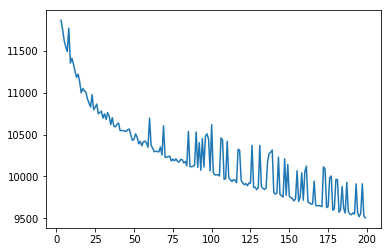

In [72]:
plt.plot(df.clusters, df.inertia)

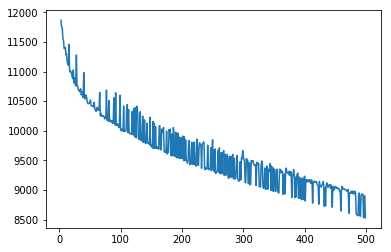

In [96]:
plt.plot(df.clusters, df.inertia)

In [118]:
clusterStatsShort = clustersStats[0:100]

In [119]:
df2 = create_dataframe_from_clusterstats(clusterStatsShort)

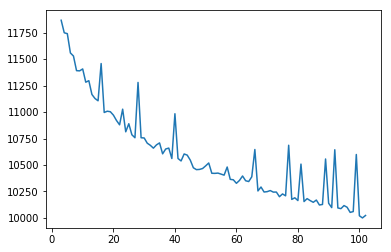

In [120]:
plt.plot(df2.clusters, df2.inertia)

In [397]:
kmx40 = KMeans(n_clusters = 40, init = 'k-means++', max_iter = 100, n_init = 1, verbose = True)
res40 = kmx40.fit(v)

Initialization complete
Iteration  0, inertia 15899.590
Iteration  1, inertia 8681.834
Iteration  2, inertia 8587.695
Iteration  3, inertia 8550.049
Iteration  4, inertia 8532.254
Iteration  5, inertia 8517.487
Iteration  6, inertia 8507.402
Iteration  7, inertia 8501.490
Iteration  8, inertia 8499.200
Iteration  9, inertia 8497.362
Iteration 10, inertia 8495.806
Iteration 11, inertia 8492.475
Iteration 12, inertia 8488.005
Iteration 13, inertia 8485.835
Iteration 14, inertia 8484.457
Iteration 15, inertia 8482.605
Iteration 16, inertia 8481.569
Iteration 17, inertia 8481.233
Iteration 18, inertia 8480.920
Iteration 19, inertia 8480.726
Iteration 20, inertia 8480.555
Iteration 21, inertia 8480.476
Iteration 22, inertia 8480.438
Iteration 23, inertia 8480.427
Converged at iteration 23: center shift 0.000000e+00 within tolerance 2.428495e-09


In [398]:
np.unique(kmx40.labels_, return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([ 200,  180,  395,   90,  142,  494,  439,  185,  394,  136,  252,
          29,  397,  215,  180,  138,  132,  155,  101,  190,  275,  763,
         104,  264,   74,   84,  382,   29,  253,   33,  177,   63,   85,
         208,   44,   79, 1917,  149,  135,  124], dtype=int64))

In [399]:
def aggregate_clusters_text(kmRes, cleanArticles):
    aggregatedTexts = {}
    for i,cluster in enumerate(kmRes.labels_):
        docTuple = cleanArticles[i]
        docId, docHtml, docTxt = docTuple
        if cluster not in aggregatedTexts.keys():
            aggregatedTexts[cluster] = ([docId], docTxt)
        else:
            items, txt = aggregatedTexts[cluster]
            items.append(docId)
            aggregatedTexts[cluster] = (items, txt + " " + docTxt)
            
    return aggregatedTexts

In [400]:
def tokenize_aggr_text_map(inputData):
    result = {}
    for cix in  inputData:
        itemAggrData = inputData[cix]
        ids, aggrTxt = itemAggrData
        words = word_tokenize(aggrTxt.lower())
        result[cix] = (ids, words)
        
    return result

In [401]:
def aggr_text_no_stop_words(aggrTxtTokenized):
    result = {}
    for cix in  aggrTxtTokenized:
        ids,words = aggrTxtTokenized[cix]
        cleanWords = remove_stopwords(words)
        result[cix] = (ids, cleanWords)
        
    return result

In [402]:
def clustered_words_freq_stats(clustersWordsMap, topWordsCount):
    result = {}
    for cix in  clustersWordsMap:
        ids,cleanWords = clustersWordsMap[cix]
        wordsCountMap = FreqDist(cleanWords)
        topWords = nlargest(topWordsCount, wordsCountMap, key = wordsCountMap.get)
        result[cix] = (ids, topWords)
        
    return result               

In [403]:
aggrTxt = aggregate_clusters_text(kmx40, cleanArticles)

In [404]:
tokenizedClustersMap = tokenize_aggr_text_map(aggrTxt)

In [405]:
tokenizedClustersMapNoStopWords = aggr_text_no_stop_words(tokenizedClustersMap)

In [406]:
clustersTopWords = clustered_words_freq_stats(tokenizedClustersMapNoStopWords, 10)

In [407]:
for cix in clustersTopWords:
    print(clustersTopWords[cix][1], len(clustersTopWords[cix][0]))

['percent', 'orders', 'quarter', 'million', 'power', 'revenues', 'us', 'growth', 'order', 'year'] 180
['business', 'customers', 'new', 'customer', 'team', 'year', 'growth', 'us', 'also', 'service'] 382
['brand', 'betts', 'thomas', 'new', 'products', 'global', 'customers', 'business', 'us', 'one'] 79
['power', 'hvdc', 'technology', 'transmission', 'link', 'wind', 'grid', 'project', 'energy', 'system'] 185
['power', 'transmission', 'substations', 'technology', 'electricity', 'automation', 'substation', 'grid', 'million', 'supply'] 252
['power', 'industrial', 'products', 'customers', 'digital', 'new', 'future', 'technology', 'solutions', 'control'] 439
['manager', 'bu', 'product', 'business', 'role', 'global', 'unit', 'new', 'management', 'products'] 494
['industrial', 'new', 'robotics', 'digital', 'automation', 'robots', 'solutions', 'robot', 'technology', 'customers'] 397
['new', 'team', 'employees', 'business', 'work', 'also', 'one', 'time', 'global', 'information'] 1917
['hr', 'busine

In [409]:
stats100 = gather_clustering_stats(v)

3
Initialization complete
Iteration  0, inertia 18197.373
Iteration  1, inertia 9262.777
Iteration  2, inertia 9233.155
Iteration  3, inertia 9229.765
Iteration  4, inertia 9228.830
Iteration  5, inertia 9228.481
Iteration  6, inertia 9228.327
Iteration  7, inertia 9228.288
Iteration  8, inertia 9228.270
Iteration  9, inertia 9228.263
Iteration 10, inertia 9228.256
Iteration 11, inertia 9228.253
Iteration 12, inertia 9228.252
Iteration 13, inertia 9228.251
Converged at iteration 13: center shift 0.000000e+00 within tolerance 2.428495e-09
4
Initialization complete
Iteration  0, inertia 17978.026
Iteration  1, inertia 9241.555
Iteration  2, inertia 9198.838
Iteration  3, inertia 9191.825
Iteration  4, inertia 9190.169
Iteration  5, inertia 9189.419
Iteration  6, inertia 9188.921
Iteration  7, inertia 9188.470
Iteration  8, inertia 9188.038
Iteration  9, inertia 9187.702
Iteration 10, inertia 9187.434
Iteration 11, inertia 9187.312
Iteration 12, inertia 9187.262
Iteration 13, inertia 9187

Iteration 30, inertia 8982.867
Converged at iteration 30: center shift 0.000000e+00 within tolerance 2.428495e-09
10
Initialization complete
Iteration  0, inertia 17214.253
Iteration  1, inertia 9103.338
Iteration  2, inertia 9036.688
Iteration  3, inertia 9017.830
Iteration  4, inertia 9010.077
Iteration  5, inertia 9006.371
Iteration  6, inertia 9003.820
Iteration  7, inertia 9001.449
Iteration  8, inertia 8999.960
Iteration  9, inertia 8999.158
Iteration 10, inertia 8998.318
Iteration 11, inertia 8997.043
Iteration 12, inertia 8994.448
Iteration 13, inertia 8990.922
Iteration 14, inertia 8983.047
Iteration 15, inertia 8956.200
Iteration 16, inertia 8955.322
Iteration 17, inertia 8955.013
Iteration 18, inertia 8954.785
Iteration 19, inertia 8954.634
Iteration 20, inertia 8954.520
Iteration 21, inertia 8954.417
Iteration 22, inertia 8954.250
Iteration 23, inertia 8954.121
Iteration 24, inertia 8954.074
Iteration 25, inertia 8954.055
Iteration 26, inertia 8954.035
Iteration 27, inertia

Iteration 20, inertia 8811.376
Iteration 21, inertia 8810.411
Iteration 22, inertia 8810.277
Iteration 23, inertia 8810.170
Iteration 24, inertia 8810.031
Iteration 25, inertia 8809.923
Iteration 26, inertia 8809.849
Iteration 27, inertia 8809.811
Iteration 28, inertia 8809.786
Iteration 29, inertia 8809.781
Iteration 30, inertia 8809.767
Converged at iteration 30: center shift 0.000000e+00 within tolerance 2.428495e-09
18
Initialization complete
Iteration  0, inertia 16805.945
Iteration  1, inertia 8937.172
Iteration  2, inertia 8850.531
Iteration  3, inertia 8817.620
Iteration  4, inertia 8803.171
Iteration  5, inertia 8794.460
Iteration  6, inertia 8789.263
Iteration  7, inertia 8786.083
Iteration  8, inertia 8783.931
Iteration  9, inertia 8782.445
Iteration 10, inertia 8781.213
Iteration 11, inertia 8780.806
Iteration 12, inertia 8780.358
Iteration 13, inertia 8780.104
Iteration 14, inertia 8779.672
Iteration 15, inertia 8778.395
Iteration 16, inertia 8776.561
Iteration 17, inertia

Iteration  2, inertia 8808.826
Iteration  3, inertia 8770.135
Iteration  4, inertia 8748.652
Iteration  5, inertia 8737.903
Iteration  6, inertia 8728.922
Iteration  7, inertia 8723.292
Iteration  8, inertia 8717.157
Iteration  9, inertia 8711.100
Iteration 10, inertia 8707.949
Iteration 11, inertia 8706.096
Iteration 12, inertia 8704.587
Iteration 13, inertia 8703.462
Iteration 14, inertia 8702.837
Iteration 15, inertia 8702.356
Iteration 16, inertia 8702.020
Iteration 17, inertia 8701.843
Iteration 18, inertia 8701.771
Iteration 19, inertia 8701.736
Iteration 20, inertia 8701.676
Iteration 21, inertia 8701.641
Iteration 22, inertia 8701.606
Iteration 23, inertia 8701.579
Iteration 24, inertia 8701.564
Iteration 25, inertia 8701.490
Iteration 26, inertia 8701.479
Converged at iteration 26: center shift 0.000000e+00 within tolerance 2.428495e-09
25
Initialization complete
Iteration  0, inertia 16419.821
Iteration  1, inertia 8873.532
Iteration  2, inertia 8785.737
Iteration  3, inertia

Iteration  5, inertia 8922.500
Iteration  6, inertia 8895.814
Iteration  7, inertia 8865.059
Iteration  8, inertia 8849.943
Iteration  9, inertia 8842.615
Iteration 10, inertia 8836.750
Iteration 11, inertia 8829.529
Iteration 12, inertia 8821.976
Iteration 13, inertia 8816.854
Iteration 14, inertia 8814.945
Iteration 15, inertia 8814.071
Iteration 16, inertia 8813.596
Iteration 17, inertia 8813.405
Iteration 18, inertia 8813.265
Iteration 19, inertia 8813.143
Iteration 20, inertia 8813.079
Iteration 21, inertia 8813.040
Iteration 22, inertia 8813.007
Iteration 23, inertia 8812.988
Iteration 24, inertia 8812.976
Iteration 25, inertia 8812.972
Iteration 26, inertia 8812.971
Converged at iteration 26: center shift 0.000000e+00 within tolerance 2.428495e-09
33
Initialization complete
Iteration  0, inertia 16150.971
Iteration  1, inertia 8727.646
Iteration  2, inertia 8620.850
Iteration  3, inertia 8585.678
Iteration  4, inertia 8572.885
Iteration  5, inertia 8566.811
Iteration  6, inertia

Iteration  2, inertia 8582.805
Iteration  3, inertia 8548.202
Iteration  4, inertia 8530.050
Iteration  5, inertia 8513.582
Iteration  6, inertia 8507.231
Iteration  7, inertia 8504.154
Iteration  8, inertia 8502.332
Iteration  9, inertia 8500.901
Iteration 10, inertia 8499.919
Iteration 11, inertia 8499.455
Iteration 12, inertia 8498.917
Iteration 13, inertia 8498.678
Iteration 14, inertia 8498.504
Iteration 15, inertia 8498.332
Iteration 16, inertia 8498.182
Iteration 17, inertia 8497.931
Iteration 18, inertia 8497.659
Iteration 19, inertia 8497.377
Iteration 20, inertia 8497.172
Iteration 21, inertia 8496.896
Iteration 22, inertia 8496.410
Iteration 23, inertia 8496.216
Iteration 24, inertia 8495.891
Iteration 25, inertia 8495.710
Iteration 26, inertia 8495.429
Iteration 27, inertia 8495.271
Iteration 28, inertia 8495.233
Converged at iteration 28: center shift 0.000000e+00 within tolerance 2.428495e-09
42
Initialization complete
Iteration  0, inertia 15797.482
Iteration  1, inertia

Initialization complete
Iteration  0, inertia 15825.642
Iteration  1, inertia 8593.858
Iteration  2, inertia 8485.980
Iteration  3, inertia 8440.626
Iteration  4, inertia 8424.311
Iteration  5, inertia 8417.431
Iteration  6, inertia 8413.157
Iteration  7, inertia 8409.606
Iteration  8, inertia 8407.166
Iteration  9, inertia 8404.820
Iteration 10, inertia 8402.324
Iteration 11, inertia 8400.985
Iteration 12, inertia 8399.870
Iteration 13, inertia 8398.598
Iteration 14, inertia 8396.441
Iteration 15, inertia 8394.075
Iteration 16, inertia 8391.884
Iteration 17, inertia 8389.868
Iteration 18, inertia 8389.350
Iteration 19, inertia 8389.024
Iteration 20, inertia 8388.778
Iteration 21, inertia 8388.561
Iteration 22, inertia 8388.429
Iteration 23, inertia 8388.329
Iteration 24, inertia 8388.251
Iteration 25, inertia 8388.182
Iteration 26, inertia 8388.110
Iteration 27, inertia 8388.070
Iteration 28, inertia 8388.031
Iteration 29, inertia 8387.977
Iteration 30, inertia 8387.961
Iteration 31, 

Iteration 15, inertia 8649.762
Iteration 16, inertia 8649.157
Iteration 17, inertia 8648.679
Iteration 18, inertia 8648.347
Iteration 19, inertia 8648.133
Iteration 20, inertia 8648.049
Iteration 21, inertia 8648.031
Iteration 22, inertia 8648.015
Converged at iteration 22: center shift 0.000000e+00 within tolerance 2.428495e-09
61
Initialization complete
Iteration  0, inertia 15348.067
Iteration  1, inertia 8501.175
Iteration  2, inertia 8404.265
Iteration  3, inertia 8359.144
Iteration  4, inertia 8337.780
Iteration  5, inertia 8323.081
Iteration  6, inertia 8313.367
Iteration  7, inertia 8306.155
Iteration  8, inertia 8300.444
Iteration  9, inertia 8295.702
Iteration 10, inertia 8293.156
Iteration 11, inertia 8292.024
Iteration 12, inertia 8291.370
Iteration 13, inertia 8290.806
Iteration 14, inertia 8290.604
Iteration 15, inertia 8290.506
Iteration 16, inertia 8290.457
Iteration 17, inertia 8290.443
Converged at iteration 17: center shift 0.000000e+00 within tolerance 2.428495e-09


Iteration 25, inertia 8235.616
Iteration 26, inertia 8235.577
Iteration 27, inertia 8235.568
Iteration 28, inertia 8235.557
Converged at iteration 28: center shift 0.000000e+00 within tolerance 2.428495e-09
70
Initialization complete
Iteration  0, inertia 15195.755
Iteration  1, inertia 8455.771
Iteration  2, inertia 8353.082
Iteration  3, inertia 8307.390
Iteration  4, inertia 8284.192
Iteration  5, inertia 8273.421
Iteration  6, inertia 8265.475
Iteration  7, inertia 8258.800
Iteration  8, inertia 8254.502
Iteration  9, inertia 8251.397
Iteration 10, inertia 8249.389
Iteration 11, inertia 8248.060
Iteration 12, inertia 8247.087
Iteration 13, inertia 8246.569
Iteration 14, inertia 8246.271
Iteration 15, inertia 8246.173
Iteration 16, inertia 8246.135
Iteration 17, inertia 8246.094
Iteration 18, inertia 8245.983
Iteration 19, inertia 8245.845
Iteration 20, inertia 8245.768
Iteration 21, inertia 8245.589
Iteration 22, inertia 8245.504
Converged at iteration 22: center shift 0.000000e+00

Iteration 26, inertia 8495.161
Iteration 27, inertia 8494.968
Iteration 28, inertia 8494.644
Iteration 29, inertia 8494.232
Iteration 30, inertia 8494.037
Iteration 31, inertia 8493.928
Iteration 32, inertia 8493.905
Iteration 33, inertia 8493.892
Iteration 34, inertia 8493.882
Converged at iteration 34: center shift 0.000000e+00 within tolerance 2.428495e-09
79
Initialization complete
Iteration  0, inertia 15172.700
Iteration  1, inertia 8387.082
Iteration  2, inertia 8262.553
Iteration  3, inertia 8204.998
Iteration  4, inertia 8181.487
Iteration  5, inertia 8172.572
Iteration  6, inertia 8167.277
Iteration  7, inertia 8164.022
Iteration  8, inertia 8162.124
Iteration  9, inertia 8160.720
Iteration 10, inertia 8160.013
Iteration 11, inertia 8159.641
Iteration 12, inertia 8159.146
Iteration 13, inertia 8158.337
Iteration 14, inertia 8157.723
Iteration 15, inertia 8157.284
Iteration 16, inertia 8156.974
Iteration 17, inertia 8156.776
Iteration 18, inertia 8156.441
Iteration 19, inertia

Iteration 15, inertia 8109.573
Iteration 16, inertia 8109.449
Iteration 17, inertia 8109.173
Iteration 18, inertia 8108.551
Iteration 19, inertia 8107.697
Iteration 20, inertia 8106.556
Iteration 21, inertia 8106.024
Iteration 22, inertia 8105.570
Iteration 23, inertia 8105.515
Converged at iteration 23: center shift 0.000000e+00 within tolerance 2.428495e-09
88
Initialization complete
Iteration  0, inertia 14821.037
Iteration  1, inertia 8293.982
Iteration  2, inertia 8186.327
Iteration  3, inertia 8150.446
Iteration  4, inertia 8135.253
Iteration  5, inertia 8127.657
Iteration  6, inertia 8122.997
Iteration  7, inertia 8118.833
Iteration  8, inertia 8116.289
Iteration  9, inertia 8115.031
Iteration 10, inertia 8114.645
Iteration 11, inertia 8114.355
Iteration 12, inertia 8114.140
Iteration 13, inertia 8114.074
Iteration 14, inertia 8114.048
Iteration 15, inertia 8114.045
Converged at iteration 15: center shift 0.000000e+00 within tolerance 2.428495e-09
89
Initialization complete
Iter

Iteration  3, inertia 8114.518
Iteration  4, inertia 8092.928
Iteration  5, inertia 8082.867
Iteration  6, inertia 8077.542
Iteration  7, inertia 8074.806
Iteration  8, inertia 8072.865
Iteration  9, inertia 8071.483
Iteration 10, inertia 8070.632
Iteration 11, inertia 8070.175
Iteration 12, inertia 8069.691
Iteration 13, inertia 8069.412
Iteration 14, inertia 8069.388
Converged at iteration 14: center shift 0.000000e+00 within tolerance 2.428495e-09
96
Initialization complete
Iteration  0, inertia 14722.856
Iteration  1, inertia 8258.113
Iteration  2, inertia 8169.732
Iteration  3, inertia 8123.372
Iteration  4, inertia 8100.055
Iteration  5, inertia 8089.479
Iteration  6, inertia 8084.544
Iteration  7, inertia 8082.149
Iteration  8, inertia 8080.971
Iteration  9, inertia 8079.787
Iteration 10, inertia 8079.219
Iteration 11, inertia 8078.853
Iteration 12, inertia 8078.609
Iteration 13, inertia 8078.331
Iteration 14, inertia 8078.199
Iteration 15, inertia 8078.154
Iteration 16, inertia

In [410]:
df100 = create_dataframe_from_clusterstats(stats100)

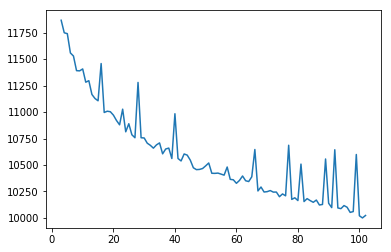

In [411]:
plt.plot(df2.clusters, df2.inertia)